In [ ]:
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from pathlib import Path

### 一、打开raster 数据。
`rasterio.open(path,mode,driver,width,height,count,dtype,crs,transform,nodata,**kwargs)`
### 函数作用：打开栅格文件，创建一个数据集对象，用于读取或写入栅格数据。
### 返回一个rasterio.io.DatasetReader或者rasterio.io.DatasetWrite对象
参数|详解
|----|----|
path：|字符串，文件路径或 URL
mode：|字符串，操作模式，默认为 'r'
driver：|字符串，指定文件格式驱动（如 'GTiff'、'JPEG' 等）
width：|整数，图像宽度（写入时必需）
height：|整数，图像高度（写入时必需）
count：|整数，波段数量（写入时必需）
dtype：|数据类型（如 np.uint8、np.float32 等，写入时必需）
crs：|坐标系统，可接受 EPSG 代码、Proj4 字符串或 CRS 对象
transform：|仿射变换矩阵，可接受 Affine 对象或 6 元素元组
nodata：|指定无数据值
**kwargs：|其他格式特定参数


In [ ]:
with rasterio.open("https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif") as src:
    pass

"""或者src = rasterio.open(  "https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif"  )"""

### 1.1获取文件名和openmode
src.mode  
    .name

### 1.2获取文件元数据
src.crs：返回坐标系统（rasterio.crs.CRS对象）  
.transform：返回仿射变换矩阵（affine.Affine对象）  
.bounds：返回地理边界（左、下、右、上）  返回BoundingBox (left, bottom, right, top) ,可以用.bounds.left访问
.width/height：返回图像宽度 / 高度  
.count：返回波段数量  
.dtypes：返回各波段数据类型  
.nodata：返回无数据值  
.profile：返回完整元数据字典  
    .meta 返回简略元数据字典  
    .indexes 所有波段的索引  
    .res 获取空间分辨率

#### 1.2.1 .bounds 属性来自一个更基本的属性：数据集的地理空间转换。

` src.transform`>>>Affine(30.0, 0.0, 358485.0,0.0, -30.0, 4265115.0)



.transform返回一个tif格式对应的tfw文件里的六参数  
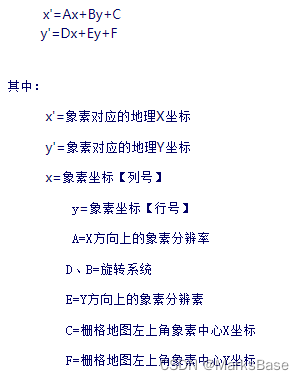  


### 直接用src.transform*(row,col)可以获得该像元对应的地理空间坐标

In [ ]:
#获得右下角的位置。
>>> dataset.transform * (dataset.width, dataset.height)
(590415.0, 4028985.0)

PS:src.transform和GDALDataset.GetGeoTransform不同  
X_geo = GT(0) + X_pixel * GT(1) + Y_line * GT(2)  
Y_geo = GT(3) + X_pixel * GT(4) + Y_line * GT(5)  
GT(0) 左上像素左上角的x坐标。  
GT(1) w-e像素分辨率/像素宽度。  
GT(2) 行旋转（通常为零）。  
GT(3) 左上像素左上角的y坐标。  
GT(4) 列旋转（通常为零）。  
GT(5) n-s像素分辨率/像素高度（北上图像为负值）。    

### 1.2.2 获取各个波段对应的数据类型字典，这样做

`dict = {i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}`

## 二、读取raster数据

## `src.read() `
作用：读取一个或多个波段的数据到 NumPy 数组  
参数：  
indexes：整数或整数列表，指定要读取的波段索引（从 1 开始）  
window：Window对象，指定读取的像素窗口  
out：预先分配的数组，用于存储输出  
masked：布尔值，是否返回MaskedArray  
boundless：布尔值，是否允许超出边界的窗口  
fill_value：边界外区域的填充值

返回值：  
单波段：2D NumPy 数组（行 × 列）  
多波段：3D NumPy 数组（波段 × 行 × 列）  

In [ ]:
with rasterio.open("https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif") as dataset:
    band1 = dataset.read(1)  # 读取第一个波段的数据
    print(band1.shape)  # 输出波段数据的形状
    print(band1) 
    print(dataset.profile)  # 输出数据集的元数据
    print(dataset.dtypes)  # 输出数据类型

由行列号（row,col）获取naddary值

In [ ]:
band1[dataset.height//2, dataset.width//2]  # 获取中心点的值

### 三、写入raster数据

### `src.write() `


作用：将数据写入一个或多个波段  
参数：  
data：NumPy 数组，要写入的数据  
indexes：整数或整数列表，指定写入的波段索引

In [ ]:
with rasterio.open("..\data\dem90m.tif",mode='w',driver='GTiff',width=dataset.width,height=dataset.height,crs=dataset.crs
    ,transform=dataset.transform,count=1,dtype=dataset.dtypes[0]) as src:
    src.write(band1,indexes=1)  # 将数据写入第一个波段
Path("..\data\dem90m.tif").exists()  # 检查文件是否存在

In [ ]:
with rasterio.open("..\data\dem90m.tif") as dataset:
    rasterio.plot.show(dataset)  # 显示栅格数据

### 四、地理参考与空间坐标变换

#### 4.1  from_origin() 函数
如果想构建仿射变换，可以用rasterio.transform.from_origin()函数      
`from rasterio.transform import from_origin  `
`rasterio.transform.from_origin(west,nort,xsize,ysize)`     
返回值：affine.Affine对象   
参数：    
west：左上角 x 地理坐标    
north：左上角 y 地理坐标    
xsize：x 方向分辨率（像素宽度）     
ysize：y 方向分辨率（像素高度，通常为负值）

In [ ]:
from_origin() 通常在创建新的栅格数据集时使用

#### 4.2 rowcol() 函数
如果已知地理坐标，想转换为像素行列号，使用rasterio.transform.rowcol()函数   
`from rasterio.transform import rowcol  `   
`rowcol(transfrom,xs,ys,op)`    
或者src.rowcol() 方法
返回值：(行号，列号) 元组       
参数：      
transform：仿射变换矩阵     
xs：x 坐标（单个值或数组）  
ys：y 坐标（单个值或数组）  
op：处理浮点坐标的函数（如np.floor、np.round）

***ps:src.rowcol()是src.index(x,y )的前置版本***

In [ ]:
from rasterio.transform import rowcol,from_origin
x,y = (100,150,170),(35,45,50)
row,col = rowcol(from_origin(100,30,1,-1),xs=x,ys=y,op=np.floor)
print(row,col)
for row,col in zip(row,col):
    print(f'row:{row},col:{col}')

#### 4.3 xy() 函数
如果已知行列号(row,col)想要获取地理坐标，使用rasterio.transform.xy()函数    
返回值：(x 坐标，y 坐标) 元组   
`from rasterio.transform import xy  `       
`xy(transform,rows,cols,offset)`   
或者 src.xy()   
参数：      
transform：仿射变换矩阵     
rows：行号（单个值或数组）      
cols：列号（单个值或数组）  
offset：坐标偏移，0.0 为左上角，0.5 为中心  

In [ ]:
with rasterio.open('../data/dem90m.tif') as src:
    row, col = 100, 150               # 行、列索引（0 起始）
    x, y = src.xy(row, col)           # 默认 offset='center'
    print(f'像素 (row={row}, col={col}) 的中心坐标为 ({x}, {y})')
    print(f'像素 (row={row}, col={col}) 的值是 {src.read(1)[row, col]}')

### 五、rasterio.wrap模块


### 5.1 reproject()函数
作用：将栅格数据从一个坐标系统重投影到另一个坐标系统。
`from rasterio.warp import reproject,Resampling`    
`reproject(source, destination, src_transform, src_crs, dst_transform, dst_crs, resampling=Resampling.nearest, num_threads=1)`  
参数：  
source：源数据，可以是数组、波段对象或数据集    
destination：目标数组或波段对象     
src_transform：源数据仿射变换   
src_crs：源数据坐标系统     
dst_transform：目标数据仿射变换     
dst_crs：目标数据坐标系统   
resampling：重采样方法（Resampling枚举）    
num_threads：用于并行处理的线程数   

### 5.2  calculate_default_transform() 函数

作用：计算重投影的默认变换参数和尺寸    
`from rasterio.warp import calculate_default_transform`     
`calculate_default_transform(src_crs, dst_crs, width, height,resolution, *bounds)`    
参数：  
src_crs：源坐标系统     
dst_crs：目标坐标系统   
width：源数据宽度   
height：源数据高度  
resolution：目标分辨率(1000,1000)单位米或者度,

left/bottom/right/top：源数据地理边界   用*src.bounds代替      
返回值：(transform, width, height) 元组 

#### ps：重投影一般方法

1.打开src   
2. 基于dst.crs和src.meta计算dst.transform(calculate_default_transform)      
3. 更新元数据信息profile=src.meta.copy()    
4. 打开dst,键入fp,mode,**profile        
5. 遍历src.read(i),     
6. 创建目标空数组，dst_array = np.empty((dst_height, dst_width), dtype=profile['dtype'])，  
7. 使用reproject将 重投影后数据写入dst_array    
8. dst.write(dst_array, i)  
   

In [53]:
#查看元数据字典
with rasterio.open('../data/dem90m_3857.tif',mode='r',driver='GTiff') as src:
    print(src.meta)
    print(src.profile)
    print(src.res)
    print(src.bounds)
    print(src.driver)
    print(src.count)
    print(src.dtypes)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4269, 'height': 3113, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(90.0, 0.0, -13442488.3428,
       0.0, -89.99579177642138, 4668371.5775)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4269, 'height': 3113, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(90.0, 0.0, -13442488.3428,
       0.0, -89.99579177642138, 4668371.5775), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
(90.0, 89.99579177642138)
BoundingBox(left=-13442488.3428, bottom=4388214.6777, right=-13058278.3428, top=4668371.5775)
GTiff
1
('int16',)


In [67]:
from rasterio.warp  import reproject,calculate_default_transform,Resampling
import rasterio
import numpy as np
#dst_crs
dst_crs = 'EPSG:4326'
#打开dem90m_3857.tif
src = rasterio.open('../data/dem90m_3857.tif',mode='r',driver='GTiff')
dst_transform,dst_width,dst_height = calculate_default_transform(
src.crs,dst_crs,
src.width,
src.height,
resolution=(0.00045,0.00045),
*src.bounds)
#设置目标元数据
profile={
    'driver': src.driver, 
    'dtype': src.dtypes[0], 
    'nodata': src.nodata, 
    'width': dst_width, 
    'height': dst_height, 
    'count': src.count, 
    'crs':dst_crs , 
    'transform': dst_transform,
}
#打开目标路径dem50m_4326.tif
with rasterio.open('../data/dem50m_4326.tif',mode='w',**profile) as dst:
    for i in range(1,src.count+1):
        #读取src第i个波段数据
        src_array = src.read(i)
        #创建空数组
        dst_array = np.empty(shape=(dst.height,dst.width),dtype=src.dtypes[i-1])
        #重投影
        reproject(
            #源文件参数
            source=src_array,
            src_transform=src.transform,
            src_crs=src.crs,
            #目标文件参数
            destination=dst_array,
            dst_transform=dst.transform,
            dst_crs=dst_crs,
            #重投影方法
            resampling=Resampling.bilinear
                )
       #写入目标文件第i个波段
        dst.write(dst_array,i)
src.close()

In [68]:
#读取重投影后文件的元数据
dst = rasterio.open('../data/dem50m_4326.tif',mode='r')
print(dst.meta)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 7669, 'height': 4429, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00045, 0.0, -120.75592734935736,
       0.0, -0.00045, 38.62692343418839)}
